<a href="https://colab.research.google.com/github/cesclondon87/gated-rnns-btc/blob/master/rnn_btc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.


# New Section

In [0]:
data = pd.read_csv('/content/btc-usd-history.csv', index_col = None)


In [4]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...,...
2051,2020-04-29,7806.712402,8871.753906,7786.049316,8801.038086,8801.038086,6.020105e+10
2052,2020-04-30,8797.669922,9440.650391,8533.255859,8658.553711,8658.553711,6.696463e+10
2053,2020-05-01,8672.782227,9048.023438,8667.763672,8864.766602,8864.766602,4.406839e+10
2054,2020-05-02,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [6]:
data.dtypes


Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [0]:
data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
price_column = 'Close'
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

In [8]:
data

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2020-04-29,8801.038086
2020-04-30,8658.553711
2020-05-01,8864.766602


In [0]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(data, test_size=0.2)

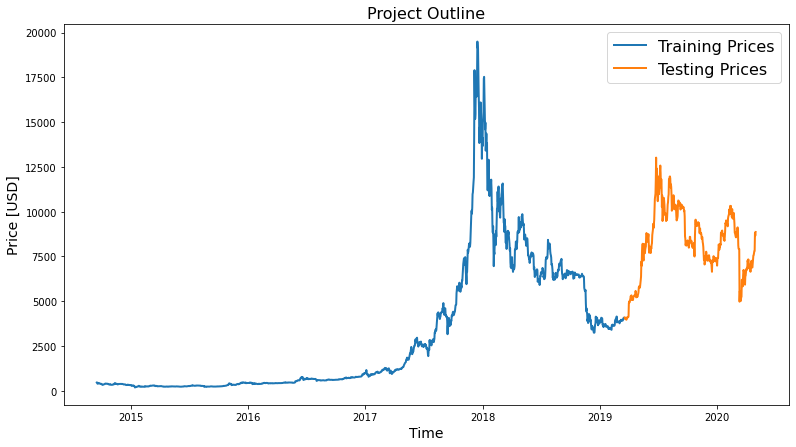

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[price_column], test[price_column], 'Training Prices', 'Testing Prices', title='Project Outline')

In [0]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [0]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [0]:
def prepare_data(df, price_column, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[price_column][window_len:].values
    y_test = test_data[price_column][window_len:].values
    if zero_base:
        y_train = y_train / train_data[price_column][:-window_len].values - 1
        y_test = y_test / test_data[price_column][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [0]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model
  

In [0]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [16]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data, price_column, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
1640/1640 [==============================] - 1s 523us/step - loss: 0.0046
Epoch 2/100
1640/1640 [==============================] - 0s 194us/step - loss: 0.0029
Epoch 3/100
1640/1640 [==============================] - 0s 194us/step - loss: 0.0024
Epoch 4/100
1640/1640 [==============================] - 0s 187us/step - loss: 0.0021
Epoch 5/100
1640/1640 [==============================] - 0s 197us/step - loss: 0.0019
Epoch 6/100
1640/1640 [==============================] - 0s 196us/step - loss: 0.0018
Epoch 7/100
1640/1640 [==============================] - 0s 190us/step - loss: 0.0017
Epoch 8/100
1640/1640 [==============================] - 0s 187us/step - loss: 0.0017
Epoch 9/100
1640/1640 [==============================] - 0s 190us/step - loss: 0.0016
Epoch 10/100
1640/1640 [==============================] - 0s 189us/step - loss: 0.0016
Epoch 11/100
1640/1640 [==============================] - 0s 186us/step - loss: 0.0016
Epoch 12/100
1640/1640 [============================

In [0]:
targets = test[price_column][window_len:]
preds = model.predict(X_test).squeeze()

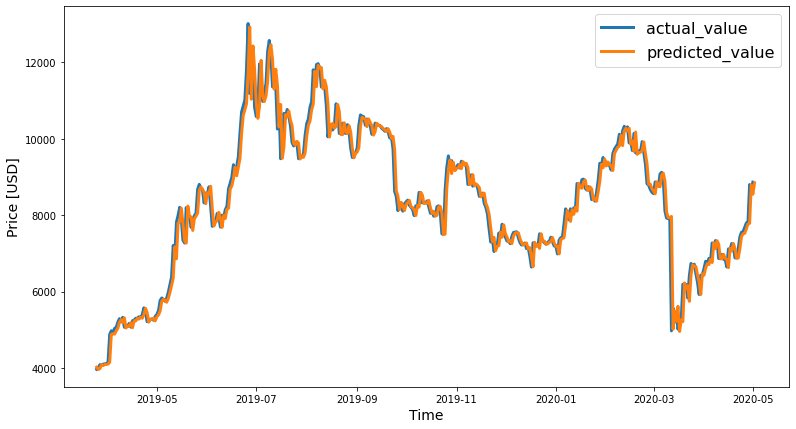

In [18]:
preds = test[price_column].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)